In [1]:
import numpy as np
import time
from scipy import misc, ndimage
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
from data_loader import *
from data_visualizer import *

np.random.seed(2018)

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Dropout,  Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from sklearn.metrics import accuracy_score, f1_score
from keras.models import load_model
from keras.utils import plot_model
from keras.optimizers import SGD, Adam
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras_sequential_ascii import keras2ascii
from sklearn.metrics import accuracy_score, f1_score
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
#inicializace dat
x_train, y_train = load_data()
x_test, y_test = load_test_data()
print(x_train.shape)
print(x_test.shape)

(6625, 64, 64, 3)
(700, 64, 64, 3)


(6592, 64, 64, 3)
(733, 64, 64, 3)


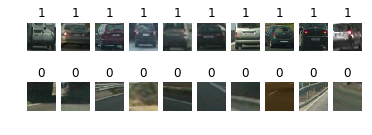

In [6]:
#zobrazení příkladů trénovacího souboru
visualize_examples(x_train, y_train, 10)

In [3]:
# vytvoření validačního souboru, jelikož při zvětšeném objemu dat, je nuté ho vytvořit ručně
def create_val_set(x_train, y_train):
# poměr rozdělení
    split = 0.8
    images_n = x_train.shape[0]
    
# rozdělení indexů poměru a zamýchání indexů
    split_index = int(split * images_n)
    mix_data = np.random.permutation(images_n)
    train_indices = mix_data[0:split_index]
    val_indices = mix_data[split_index:]

# vytvoření nových matic s daty
    new_x_train = x_train[train_indices, :, :]
    new_y_train = y_train[train_indices]
    x_val = x_train[val_indices, :, :]
    y_val = y_train[val_indices]
    
    return new_x_train, new_y_train, x_val, y_val  

In [14]:
# vytvoření modelu neuronové sítě
def train_model(x_train, y_train, epochs, batch_size, optimizer):
    
    #inicializace parametrů
    epochs_n = epochs
    batch_size_n = batch_size
    
   # rozdělení na nový trénovací a validační soubor
    x_train_n, y_train_n, x_val, y_val = create_val_set(x_train, y_train)
    
    # nastavení ImageDataGeneratoru
    datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        vertical_flip=True,
        fill_mode="nearest")
        
    #vytvoření konvolučního modelu
    model = Sequential()
 
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64,64,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64,(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(3, 3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    #nastavení optimizeru
    if (optimizer == 'sgd'):
        sgd = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True)
        model.compile(optimizer = sgd, loss = "binary_crossentropy", metrics = ["accuracy"])
        
    elif (optimizer == 'adam'):
        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
        model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])

        
    print("Máme: " + str(x_train_n.shape[0]) + ' trénovacích obrázků a :' + str(x_val.shape[0]) + ' validačních obrázků')    
    start = time.time()
    # vytvoření logu trénování
    csv_logger = CSVLogger('nn_deep_conv_1_sgd_400e_aug.log')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
    # trénování modelu model.fit()
    history =  model.fit_generator(datagen.flow(x_train_n, y_train_n, batch_size = batch_size_n),
                                   samples_per_epoch = len(x_train), epochs = epochs_n, 
                                   validation_data = (x_val, y_val), verbose=1, callbacks=[csv_logger, reduce_lr])
    end = time.time()
    
    # vytiskne přehled modelu
    print("Model took %0.2f seconds to train"%(end - start))
    print(model.summary())
    keras2ascii(model)
    print_graphs(history)
    
    # uložení modelu jako .h5
    model.save(r'C:\Users\Petr\Desktop\Bakalářská práce\Neural_networks\deep_nn\nn_deep_conv_1_sgd_400e_aug.h5')
    
    return history, model

(6630, 64, 64, 3)
(700, 64, 64, 3)
Máme: 5304 trénovacích obrázků a :1326 validačních obrázků


C:\Users\Petr\Anaconda3\envs\neural\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=400, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=207)`


Epoch 1/400


C:\Users\Petr\Anaconda3\envs\neural\lib\site-packages\keras_preprocessing\image.py:959: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Petr\Anaconda3\envs\neural\lib\site-packages\keras_preprocessing\image.py:967: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


207/207 [==============================] - 83s 400ms/step - loss: 0.6715 - acc: 0.5751 - val_loss: 0.6594 - val_acc: 0.6116
Epoch 2/400
207/207 [==============================] - 83s 401ms/step - loss: 0.6150 - acc: 0.6725 - val_loss: 0.6116 - val_acc: 0.6335
Epoch 3/400
207/207 [==============================] - 90s 434ms/step - loss: 0.5430 - acc: 0.7307 - val_loss: 0.5644 - val_acc: 0.6885
Epoch 4/400
207/207 [==============================] - 88s 427ms/step - loss: 0.5019 - acc: 0.7674 - val_loss: 0.4939 - val_acc: 0.7564
Epoch 5/400
207/207 [==============================] - 82s 398ms/step - loss: 0.4666 - acc: 0.7908 - val_loss: 0.4844 - val_acc: 0.7632
Epoch 6/400
207/207 [==============================] - 85s 409ms/step - loss: 0.4290 - acc: 0.8131 - val_loss: 0.4747 - val_acc: 0.7738
Epoch 7/400
207/207 [==============================] - 85s 410ms/step - loss: 0.4006 - acc: 0.8394 - val_loss: 0.4832 - val_acc: 0.7730
Epoch 8/400
207/207 [==============================] - 83s 4

Epoch 61/400
207/207 [==============================] - 81s 393ms/step - loss: 0.0854 - acc: 0.9698 - val_loss: 0.1127 - val_acc: 0.9548
Epoch 62/400
207/207 [==============================] - 83s 399ms/step - loss: 0.0868 - acc: 0.9663 - val_loss: 0.0971 - val_acc: 0.9630
Epoch 63/400
207/207 [==============================] - 84s 405ms/step - loss: 0.0817 - acc: 0.9705 - val_loss: 0.0724 - val_acc: 0.9713
Epoch 64/400
207/207 [==============================] - 81s 391ms/step - loss: 0.0758 - acc: 0.9707 - val_loss: 0.0740 - val_acc: 0.9683
Epoch 65/400
207/207 [==============================] - 85s 410ms/step - loss: 0.0760 - acc: 0.9721 - val_loss: 0.0653 - val_acc: 0.9729
Epoch 66/400
207/207 [==============================] - 82s 397ms/step - loss: 0.0787 - acc: 0.9697 - val_loss: 0.0679 - val_acc: 0.9721
Epoch 67/400
207/207 [==============================] - 80s 388ms/step - loss: 0.0720 - acc: 0.9718 - val_loss: 0.0750 - val_acc: 0.9698
Epoch 68/400
207/207 [===================

207/207 [==============================] - 78s 376ms/step - loss: 0.0661 - acc: 0.9754 - val_loss: 0.0641 - val_acc: 0.9713
Epoch 180/400
207/207 [==============================] - 78s 377ms/step - loss: 0.0608 - acc: 0.9789 - val_loss: 0.0610 - val_acc: 0.9744
Epoch 181/400
207/207 [==============================] - 78s 376ms/step - loss: 0.0619 - acc: 0.9779 - val_loss: 0.0673 - val_acc: 0.9721
Epoch 182/400
207/207 [==============================] - 78s 376ms/step - loss: 0.0589 - acc: 0.9778 - val_loss: 0.0617 - val_acc: 0.9759
Epoch 183/400
207/207 [==============================] - 78s 377ms/step - loss: 0.0623 - acc: 0.9746 - val_loss: 0.0636 - val_acc: 0.9744
Epoch 184/400
207/207 [==============================] - 78s 377ms/step - loss: 0.0574 - acc: 0.9775 - val_loss: 0.0661 - val_acc: 0.9751
Epoch 185/400
207/207 [==============================] - 78s 375ms/step - loss: 0.0619 - acc: 0.9753 - val_loss: 0.0645 - val_acc: 0.9744
Epoch 186/400
207/207 [=========================

207/207 [==============================] - 78s 376ms/step - loss: 0.0506 - acc: 0.9801 - val_loss: 0.0602 - val_acc: 0.9774
Epoch 298/400
207/207 [==============================] - 78s 375ms/step - loss: 0.0529 - acc: 0.9809 - val_loss: 0.0525 - val_acc: 0.9789
Epoch 299/400
207/207 [==============================] - 78s 377ms/step - loss: 0.0530 - acc: 0.9794 - val_loss: 0.0600 - val_acc: 0.9774
Epoch 300/400
207/207 [==============================] - 78s 378ms/step - loss: 0.0541 - acc: 0.9808 - val_loss: 0.0555 - val_acc: 0.9781
Epoch 301/400
207/207 [==============================] - 78s 375ms/step - loss: 0.0508 - acc: 0.9822 - val_loss: 0.0659 - val_acc: 0.9736
Epoch 302/400
207/207 [==============================] - 78s 376ms/step - loss: 0.0550 - acc: 0.9809 - val_loss: 0.0593 - val_acc: 0.9781
Epoch 303/400
207/207 [==============================] - 78s 376ms/step - loss: 0.0508 - acc: 0.9817 - val_loss: 0.0550 - val_acc: 0.9796
Epoch 304/400
207/207 [=========================

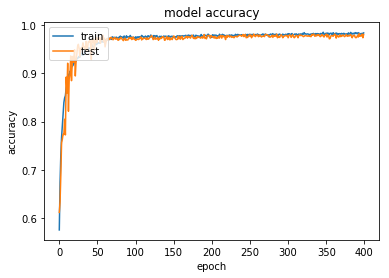

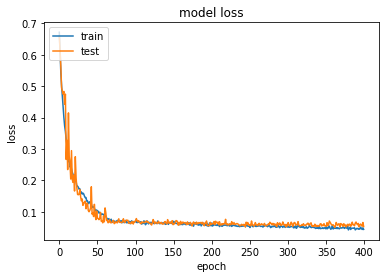

In [15]:
# trénování modelu
history, model = train_model(x_train, y_train, 400, 32, 'sgd')

In [10]:
# vytvoření modelu jako obrázku
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(model, to_file='model_plot_5_layers_aug.png', show_shapes=True, show_layer_names=True)

In [99]:
#odstranit stávající model
del model

In [8]:
#načtení uloženého modelu
model = load_model('nn_deep_conv_1_adam_50e_aug.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
__________

In [5]:
# metoda pro udělání predikce na testovacím souboru
def prediction_test(model, x_test, y_test):
    
    test_predictions = model.predict(x_test)
    test_predictions = np.round(test_predictions)

    # vrácení přesnosti predikce
    accuracy = accuracy_score(y_test, test_predictions)
    print("Přesnost testovacího datasetu: " + str(accuracy * 100) + "%")
    
    return test_predictions

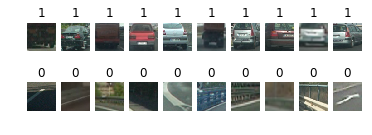

In [13]:
# zobrazení testovacích dat
visualize_examples(x_test, y_test, 10)

In [9]:
# predikce testovacího souboru
test_predictions = prediction_test(model, x_test, y_test)

Přesnost testovacího setu: 99.28571428571429%


počet špatných odhadů: 5


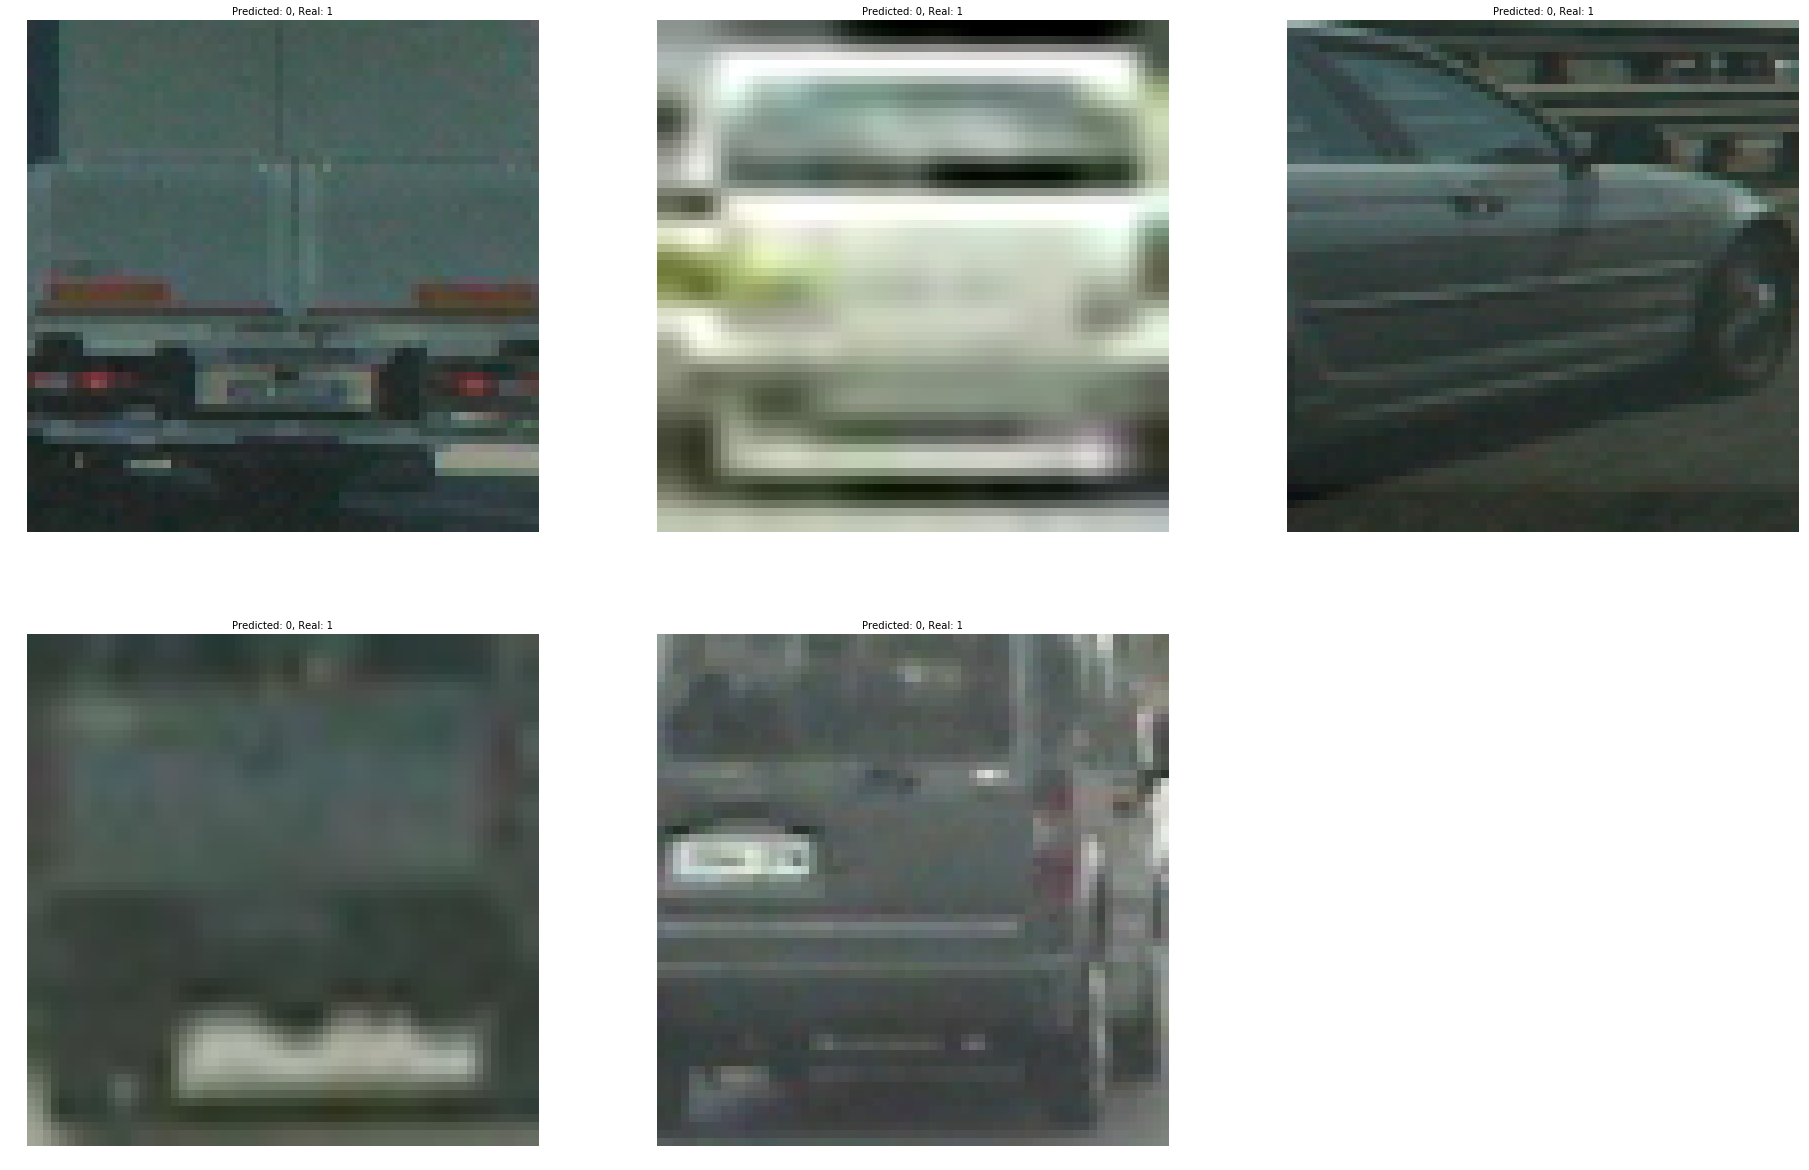

In [10]:
# zobrazení nesprávně označených obrázků
visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())